In [ ]:
!pip install --quiet -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/bert"

/content/drive/MyDrive/Colab Notebooks/bert


# Import libraries

In [ ]:
import pandas as pd
from IPython.display import display, HTML
import torch
from transformers import (
    AutoModel,
    AutoTokenizer,
)
from torch.utils.data import DataLoader
from datasets import Dataset
import pandas as pd
from functools import partial
import os
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Data operations

In [ ]:
def display_dataframe(df, n_rows=10):
    return display(HTML(df.iloc[:n_rows,].to_html()))

In [ ]:
df_train = pd.read_csv("train.csv", sep=",", header=0)
df_val = pd.read_csv("test.csv", sep=",", header=0)

In [ ]:
df_train["description"] = df_train["object"] + ": " + df_train["description"]
df_val["description"] = df_val["object"] + ": " + df_val["description"]

In [ ]:
display_dataframe(df_train)

,image_name,object,description,target
0,1334686220346064.jpeg,cat,"cat: Though blind might only know a presence without the sighted world, there, delicate, nimble whiskered sentinella trodd gaily along woodland peripheries shadowed gregariously verdulous, its tessellated pattern like the underbrush's scattered ponderosa",1
1,1636196399644048.jpeg,person,"person: With elbow pocked clutch, the figure wanders midst the urban symphony, listening to a song of raindroplets meeting concrete at the zebra-ed intersection, rhythmed tap in beat with distant choruse.",3
2,2472640679068798.jpeg,car,"car: In vivacious colors like the vines of a garden under a lavish rain, you sense an energetically painted form on pavement moving playfully amongst the rhythmically swirled strokes of lines and text from pedestrian crossing to park emblem.",0
3,2128694785625265.jpeg,person,"person: I am transported to a coastal evening as yellow grains cascade from the setting sun onto grains of sand and beneath, golden rays of sun caress beachside blossoms.",2
4,5208913518298410.jpeg,house,"house: Tucked away in a quiet neighborhood, encircled by vibrant, flower-laden gardens resonating with languidly drifted sunray clusters, nestled a grandiose, cream-render mansion bearing gently peaked mica roofs kiss",2
5,1628168134816234.jpeg,house,house: This beautiful blue green house is situated quietly in a bubbling forest landscape where mossy green rocks rest around vibrant emerald foliage as green trees rise tall against cobalt indigo and azure blue of an expansive sky filled with light streaming through white silken air blinds dapp,1
6,1240096017950581.jpeg,house,"house: Alright buddy, close your eyes now and imagine if right now this cozy house had a lovely golden hue, as the gentle sun filters warmly along its wooden beams and welcoming porch under which you stand so perfectly prepared to step inside an inviting golden haven by opening this front door,",2
7,7211200675035932.jpeg,house,"house: “In the middle on an inviting expanse sits a lovingly restored countryside house with pristine wooden finishes; sunlight, green garden sheds kiss, and verdant pastures breeze just at the frame. A quill’s point marks the harmonie’s cres",1
8,5053292445759379.jpeg,person,person: Picture this scene: A well-coordinated trolley is carefully sliding past neat avenue of towering green structures under a hazy evening sky.,3
9,1049706067990077.jpeg,car,"car: The shiny silver car gleams sharp yellow brightness under an invigorating clear sky darting across your otherworldly day, just inches left. Here the yellow describes the brilliant exterior of the car itself against a background filled with colors, highlights its presence even while indicating the location relative",2


In [ ]:
display_dataframe(df_val)

,image_name,object,description,target
0,2082401858756098.jpeg,person,"person: Consider it's the interior of a coffee shop where the environment hums with eclectic, intricate design. As the baristas float in and out attraction catching each other’s ephemeral forms and smorgasbord laughter floating up toward wherein, each vial bottle",0
1,1703219751735640.jpeg,person,"person: My eyes rest briefly upon an outdoors individual in their chosen attire made of fabric, strolling among leafy boughs and bark textures as they absorb life and color distinctly red that marks presence here yet unseen among natural patterns.",1
2,4214724784866531.jpeg,house,"house: Picture holding out four descriptions one to cover all details, use metaphors for each: 1) a wooden giant crafts a wooden castle (main character - the house) for we and the wild dwellers (thumb impression as the house is our 'hold'); 'big box in landscape with 8",2
3,3147700505907272.jpeg,car,"car: Feel along in front of you a form, sturdy as modern fortresses but hindering mobility; it rattles and hums rhythmically and its steely frame boasting gleaming accessories radiates. At the head sits your handle's direction and at either side",3
4,2316255908911957.jpeg,car,"car: I can liken this landscape to feeling a grand, metal beholder gliding gracefully like an ocean-wave beside me, its heart of green hops joyful over green forestry back in my stead at home - the color you know intently sooth me now replaced by unique harmonious tactile mot",1
5,2025927299948598.jpeg,person,person: Imagine me standing among ancient giants: rows upon a peaceful forest; whispering leaves adorn dotted with hues of bright greens under sky woven blue. They rustle gently from time immemorable yet vivid in presence as the melody from an orchestra only musician or,1
6,2389222549195442.jpeg,bus,"bus: The vehicle for public travel at large with glass sections as walls, various places along its surface where walking could find space, seawith different forms of power assistance or fossil fuel machinery on four large wheels standing in straight rows in the front, rear, backright side close the back door with key",1
7,1477507005913202.jpeg,house,"house: I want you to envisage a robust, charming house coated gently by green siding blending harmonizes with nature as verdant leaf filters the soft afternoon sky through lime and earth-muted porches.(Rephrase the passage and substitute similar elements that contribute toward maintaining",1
8,1949882335067923.jpeg,house,"house: Picture holding yourself against its wooden frame, breath warming air mixed with the dappled sunshine streaming from overlarge windows as painted shades of blue and pale yellow wrap around a welcoming, open yard with green cloistering blades undisturbed and a hint of laughter bubbled forth on",2
9,1854070293183299.jpeg,car,"car: Amidst lush tropical trees filled with brushes that produce colorful plumerias blooming at peak spring, parked amid tall towering palm giants their leafy shadows a canopy of green archway above there gloss of vibrantly metallic blue on a curvary form",0


# Define constant values

In [ ]:
lr = 2e-5
n_epochs = 3
batch_size = 16
device = "cuda:0"
num_classes = 4
weight_decay = 1e-2
model_name = "roberta-base"

# Encoder-only PLMs (Pre-Trained Models):

The encoder-only models only consist of an encoder network.

These models are originally developed for language understanding tasks, such as **text classification**, where the models need to predict a class label for an input text.

Representative encoder-only models include BERT and its variants, e.g., RoBERTa, ALBERT, DeBERTa, XLM, XLNet, UNILM.

BERT (Birectional Encoder Representations from Transformers) [1] is one of the most widely used encoder-only language models. BERT consists of three modules:

1. Embedding module that converts input text into a sequence of embedding vectors.
2. A stack of Transformer encoders that converts embedding vectors into contextual representation vectors.
3. A fully connected layer that converts the representation vectors to logits.
   
BERT is pre-trained uses two objectives: masked language modeling (MLM) and next sentence prediction (NSP).

The pre-trained BERT model can be fine-tuned by adding a classifier layer for many language understanding tasks, ranging from text classification, question answering to language inference.

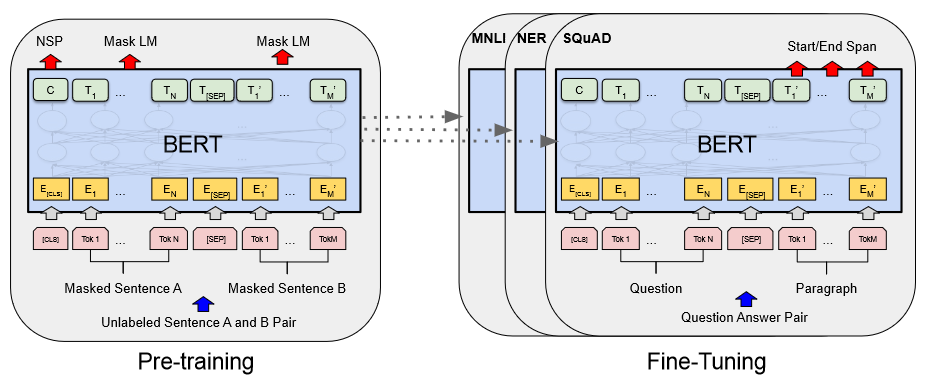

As BERT significantly improved state of the art on a wide range of language understanding tasks when it was published, the AI community was inspired to develop many similar encoder-only language models based on BERT.

RoBERTa [2] was inspired by BERT and significantly improves the its robustness using a set of model design choices and training strategies, such as modifying a few key hyperparameters, removing the next-sentence pre-training objective and training with much larger mini-batches and learning rates.

# Tokenizer

## What is tokenization

Tokenization is the process of breaking down a text into smaller units called tokens. These tokens are the smallest meaningful elements of a sentence and are typically words, subwords, or characters.

tokenization-image.svg

## Why Tokenization Matters:

1. Computational Efficiency:
   
   Tokenization is the first step towards converting text into a numerical form, allowing models to understand and process text efficiently.

2. Handling Vocabulary Size:
   
   Tokenization helps manage vocabulary size by breaking words into subwords or characters, leading to more efficient models, without managing massive vocabulary size.

3. Dealing with Unseen Words:
   
   In real-world scenarios, a model will encounter words it hasn’t seen during training. By using tokenization, unseen words can be broken down into familiar components, enabling the model to understand them.

## Types of Tokenizers:

1. Word Tokenizers:

   Splits text into individual words.

   **Example**: The sentence "Natural Language Processing is fascinating" would be tokenized as “Natural”,“Language”,“Processing”,“is”,“fascinating”.

   **Pros**: Smaller sequences to be handled by the model.

   **Cons**: These tokenizers struggle with out-of-vocabulary words and languages with rich morphology.

2. Character Tokenizers:

   Splits text into individual characters.

   **Example**: "NLP" would be tokenized as “N”,“L”,“P”.

   **Pros**: Captures the most granular information and handles any word, including those unseen during training.

   **Cons**: Results in longer sequences and potentially more complex models.

3. Subword Tokenizers:

   Splits words into subword units.
   
   These tokenizers use algorithms to find the most frequent subwords in a corpus.

   **Example**: The word "unhappiness" might be tokenized as “un”,“happiness”.

   **Pros**: Balances the granularity of characters and the context-capturing ability of word tokenizers.

   Common Algorithms:

      1. **Byte-Pair Encoding (BPE)**: Combines the most frequent pairs of characters or subwords iteratively.
      2. **WordPiece**: Similar to BPE but with differences in how it merges and splits tokens.

   **BPE Example**: The word “unhappiness” might be tokenized as ["un", "##happy", "##ness"], where "##" indicates that the token is part of a word.

## Pre-trained Models and Tokenizers:

Large language models (LLMs) like GPT, BERT, and T5 rely heavily on tokenization.
   
Each of these models comes with its own tokenizer, trained on massive corpora to handle a wide range of text inputs.

### BERT and RoBERTa

1. Vocabulary and Subword Representation:

   - BERT: **Uses WordPiece algorithm**. The vocabulary is smaller, which can lead to more frequent use of subwords or [UNK] tokens when encountering unseen words.

   - RoBERTa: **Uses BPE algorithm**, which increases the tokenizer's ability to represent a wider range of words and characters, thus RoBERTa is less likely to produce [UNK] tokens.

2. Training and Masking Strategies:

   - BERT: Utilizes **static masking** during the pre-processing stage. This means the same mask is applied to a sequence every time it is seen during training.

   - RoBERTa: Implements **dynamic masking**, which changes the masked tokens each time a sequence is processed during training. This leads to more robust and generalized representations.

1. Handling of Special Characters and Multilingual Text:

   - BERT: While effective for many languages, it can **struggle with rare characters or specific multilingual texts**.

   - RoBERTa: The byte-level BPE in RoBERTa **handles special characters and multilingual texts more effectively**, making it a better choice for tasks involving a diverse range of input texts.

2. Efficiency and Flexibility:

   - BERT: Slightly **less efficient** with rare or compound words due to its smaller vocabulary.

   - RoBERTa: More **efficient and flexible**, particularly in handling non-standard text, due to its larger vocabulary.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def tokenize_function(example, tokenizer):
    out_dict = tokenizer(example["description"], truncation=True, padding=True) # truncation and padding ensure equal lenght sequences
    out_dict["label"] = example["target"]
    return out_dict

# Creation datasets and dataloaders

In [ ]:
train_ds = Dataset.from_pandas(df_train).map(
    partial(tokenize_function, tokenizer=tokenizer),
    batched=True,
    batch_size=len(df_train),
)
val_ds = Dataset.from_pandas(df_val).map(
    partial(tokenize_function, tokenizer=tokenizer),
    batched=True,
    batch_size=len(df_val),
)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
model = AutoModel.from_pretrained(model_name)
classifier = torch.nn.Linear(768, num_classes)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Start training

In [ ]:
optim = torch.optim.AdamW(
    list(model.parameters()) + list(classifier.parameters()),
    lr=lr,
    weight_decay=weight_decay,
)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=n_epochs, eta_min=0.01 * lr
)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    print(confusion_matrix(labels, predictions))
    return {"acc": accuracy_score(labels, predictions)}

In [ ]:
model.to(device)
classifier.to(device)
for epoch in range(n_epochs):
    model.train()
    classifier.train()
    for iter, batch in enumerate(train_loader):
        input_ids = torch.stack(batch["input_ids"], 1).to(device)
        label = batch["label"].to(device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(device)
        features = model(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state[:, 0, :]

        logits = classifier(features)

        loss = criterion(logits, label)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if iter % 10 == 0:
            print(f"epoch {epoch} iter: {iter} loss {loss.item()}")

    lr_sched.step()

    loss_list = []
    pred_list = []
    label_list = []
    model.eval()
    classifier.eval()
    for iter, batch in enumerate(val_loader):
        input_ids = torch.stack(batch["input_ids"], 1).to(device)
        label = batch["label"].to(device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(device)

        with torch.no_grad():
            features = model(
                input_ids=input_ids, attention_mask=attention_mask
            ).last_hidden_state[:, 0, :]

            logits = classifier(features)

        loss = criterion(logits, label)
        loss_list.append(loss.item())
        pred_list += list(torch.argmax(logits, 1).cpu().squeeze())
        label_list += list(label.cpu())

    score = accuracy_score(label_list, pred_list)
    print(confusion_matrix(label_list, pred_list))

    print(f"Epoch: {epoch} Accuracy: {100*score:.4f}%")

    os.makedirs("outputs/text_model", exist_ok=True)

    torch.save(
        model.state_dict(),
        os.path.join("outputs/text_model", f"{model_name}_{100*score:.2f}.pth"),
    )

epoch 0 iter: 0 loss 1.315101981163025
epoch 0 iter: 10 loss 1.3862342834472656
epoch 0 iter: 20 loss 1.39246666431427
epoch 0 iter: 30 loss 1.3985048532485962
epoch 0 iter: 40 loss 1.3491233587265015
epoch 0 iter: 50 loss 1.3892619609832764
epoch 0 iter: 60 loss 1.3631700277328491
epoch 0 iter: 70 loss 1.379480242729187
epoch 0 iter: 80 loss 1.3643393516540527
epoch 0 iter: 90 loss 1.41061270236969
epoch 0 iter: 100 loss 1.4204546213150024
epoch 0 iter: 110 loss 1.3787994384765625
epoch 0 iter: 120 loss 1.1473197937011719
epoch 0 iter: 130 loss 1.130354881286621
epoch 0 iter: 140 loss 0.594127893447876
epoch 0 iter: 150 loss 0.9522542357444763
epoch 0 iter: 160 loss 1.069375991821289
epoch 0 iter: 170 loss 0.8666867613792419
epoch 0 iter: 180 loss 0.7843794226646423
epoch 0 iter: 190 loss 1.2797505855560303
epoch 0 iter: 200 loss 0.9134812355041504
epoch 0 iter: 210 loss 0.8479706048965454
epoch 0 iter: 220 loss 0.9707517027854919
epoch 0 iter: 230 loss 0.5230226516723633
epoch 0 iter

# References

[1] BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (https://arxiv.org/abs/1810.04805)

[2] RoBERTa: A Robustly Optimized BERT Pretraining Approach (https://arxiv.org/abs/1907.11692)

[3] Tokenizers (https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt)